In [2]:
import numpy as np
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

### Q1


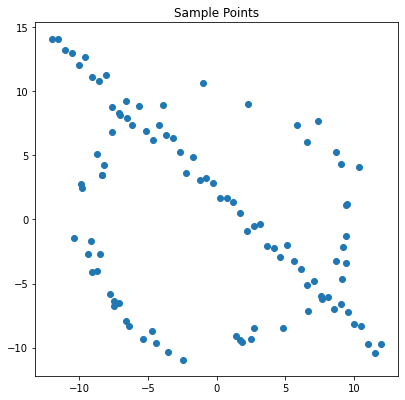

In [3]:
np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

# plot figure
plt.figure(figsize=(6.5, 6.5))
plt.plot(X_circ[:, 0], X_circ[:, 1], 'o', color="C0")
plt.plot(X_line[:, 0], X_line[:, 1], 'o', color="C0")
plt.title("Sample Points")
plt.show()


In [4]:
def getCircle(x, y, z):
    """Returns center coordinates and radius when given three points.
    Returns False if no circle can be fitted"""
    x = complex(x[0], x[1])
    y = complex(y[0], y[1])
    z = complex(z[0], z[1])
    try:
        w = (z-x)/(y-x)
        c = (x-y)*(w-abs(w)**2)/(2j*w.imag)-x
    except ZeroDivisionError:
        return False, False, False

    return -c.real, -c.imag, abs(c+x)  # (center_x, center_y, r)


def calcError(f, g, r, inliers):
    Sum = 0
    for pt in inliers:
        Sum += abs(np.sqrt((pt[0]-f)**2 +
                   (pt[1]-g)**2) - r)
    error = Sum/len(inliers)
    return error


def bestFitCircle(inliers):
    """Function to best-fit a circle to a given inlier dataset. Returns Center coordinates and radius"""
    x, y = inliers[:, 0], inliers[:, 1]
    N = len(x)
    x_mu, y_mu = np.mean(x), np.mean(y)
    u, v = (x - x_mu), (y - y_mu)

    a11 = sum(u**2)
    a22 = sum(v**2)
    a12 = a21 = sum(u*v)
    b1 = 0.5*(sum(u*(u**2 + v**2)))
    b2 = 0.5*(sum(v*(u**2 + v**2)))

    A = np.array([[a11, a12], [a21, a22]])
    B = np.array([[b1], [b2]])
    u_c, v_c = np.linalg.inv(A) @ B

    f = u_c + x_mu
    g = v_c + y_mu

    r = np.sqrt(u_c**2 + v_c**2 + (sum(u**2 + v**2))/(N))

    return f, g, r


def getInlierCount(f, g, r, X, t):

    best_fit_inliers = None
    inlier_count = 0

    for i in range(X.shape[0]):
        distance = abs(((X[i, 0] - f)**2 + (X[i, 1] - g)**2) ** 0.5 - r)

        if distance < t:
            inlier_count += 1

            if type(best_fit_inliers) == type(None):
                best_fit_inliers = np.array([X[i, :]])
            else:
                best_fit_inliers = np.concatenate(
                    (best_fit_inliers, X[i, :].reshape(1, -1)), axis=0)

    return inlier_count, best_fit_inliers


In [5]:
def RANSAC_circ(X):

    e = 0.5     # outlier ratio
    s = 3       # Number of points needed to create the estimated model
    p = 0.99    # Probability to choose number of iteration cycles
    t = 1.96 * 10/16   # treshold distance to determine inliers and outliers
    d = 50      # expected number of inliers

    iters = int(np.ceil(np.log(1-p)/np.log(1-(1-e)**s)))

    best_inlier_count = 0
    best_samples = None
    best_fit_inliers = None

    for _ in range(iters):

        # choose 3 distinct points from dataset
        [p1, p2, p3] = np.random.choice(len(X), size=3, replace=False)
        [p1, p2, p3] = X[p1, :], X[p2, :], X[p3, :]

        # get circle through the 3 points
        f, g, r = getCircle(p1, p2, p3)

        if r == None:
            continue

        inlier_count, inliers = getInlierCount(f, g, r, X, t)

        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_fit_inliers = inliers
            best_samples = [p1, p2, p3]
            best_fit_circle = [f, g, r]

    if best_inlier_count < d:
        # repeat ransac if no model found
        RANSAC_circ(X)

    ransac_circle = bestFitCircle(best_fit_inliers)  # f,g,r

    return ransac_circle, best_fit_circle, best_samples, best_fit_inliers


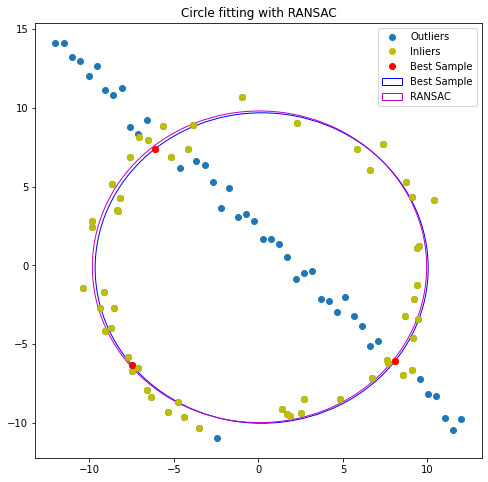

In [7]:
ransac_circle, best_fit_circle, best_samples, inliers = RANSAC_circ(X)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_circ[:, 0], X_circ[:, 1], color='C0')
ax.scatter(X_line[:, 0], X_line[:, 1], color='C0', label="Outliers")

for point in inliers:
    if np.array_equal(point, inliers[-1]):
        ax.plot(point[0], point[1], 'yo', label="Inliers")
    else:
        ax.plot(point[0], point[1], 'yo')

for point in best_samples:
    if np.array_equal(point, best_samples[-1]):
        ax.plot(point[0], point[1], 'ro', label="Best Sample")

    else:
        ax.plot(point[0], point[1], 'ro')

f, g, r = ransac_circle
ransac_circle = plt.Circle((f, g), r, color='m', fill=False, label="RANSAC")

f, g, r = best_fit_circle
best_fit_circle = plt.Circle( (f, g), r, color='b', fill=False, label="Best Sample")

ax.add_artist(best_fit_circle)
ax.add_artist(ransac_circle)
ax.set_title("Circle fitting with RANSAC")
ax.legend(loc="upper right")
plt.show()


### Q2


In [8]:
def click_event(event, x, y, flags, params):
    global points
    global click_count

    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x, y])
        click_count += 1

        cv.circle(img, (x, y), 5, (0, 0, 255), -1)
        cv.imshow('Image', img)

    if click_count == 4:
        return

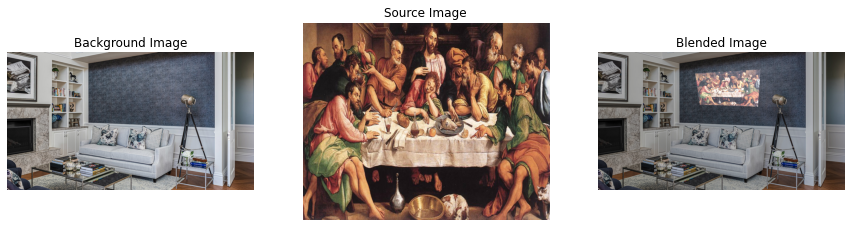

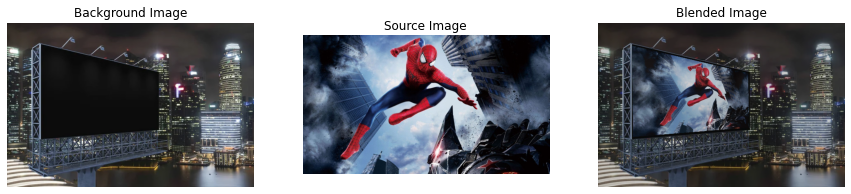

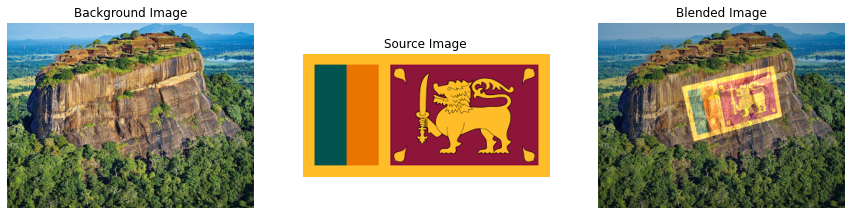

In [9]:
source_images = ['Images/painting.jpg',
                 'Images/spidey.jpg', 'Images/flag.png']

backgroung_images = ['Images/Wall.jpg', 'Images/billboard.jpg',
                     'Images/sigiriya.jpg']


coeff = [(0.8, 0.85, 0.3), (0.8, 0.8, 0.3), (0.8, 0.6, 0.3)]
images = []

for i in range(len(source_images)):
    points = []
    click_count = 0

    # Read the background image first
    img = cv.imread(backgroung_images[i], 1)

    # Display the image, set mouse handler, call click-event
    cv.imshow('Image', img)
    cv.setMouseCallback('Image', click_event)

    # After the 4 clicks the window closes
    cv.waitKey(0)
    cv.destroyAllWindows()

    # Destination image is the background image
    img_dst = cv.imread(backgroung_images[i])
    # Four corners in the destination image
    pts_dst = np.array(points)

    # Read the source image to be transformed
    img_src = cv.imread(source_images[i])
    # Width and height of the image
    w, h = img_src.shape[1], img_src.shape[0]
    # The four corners of the source
    pts_src = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]])

    # Compute Homography for the transformation
    h, status = cv.findHomography(pts_src, pts_dst)

    # Warp the source image using homography transformation into destination image
    img_out = cv.warpPerspective(img_src, h, (img_dst.shape[1], img_dst.shape[0]))
    
    # Blend the two images for better representation
    blended_img = cv.addWeighted(img_dst, coeff[i][0], img_out, coeff[i][1], coeff[i][2])
    
    images.append([img_dst, img_src, blended_img])

    cv.imshow("Blended Image", blended_img)
    cv.waitKey(0)
    cv.destroyAllWindows()

#show results
for img in images:
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    titles = ['Background Image', 'Source Image', 'Blended Image']

    for i in range(3):
        transformed_img = cv.cvtColor(img[i], cv.COLOR_BGR2RGB)
        ax[i].imshow(transformed_img)
        ax[i].set_title(titles[i])
        ax[i].axis('off')


### Q3


### a)

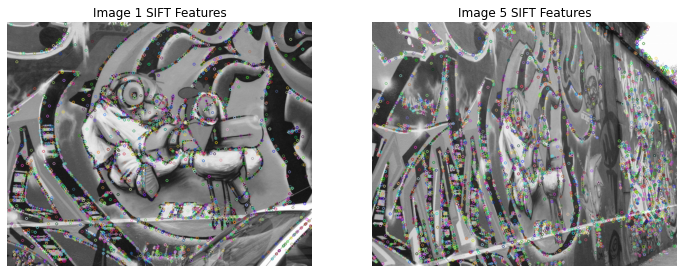

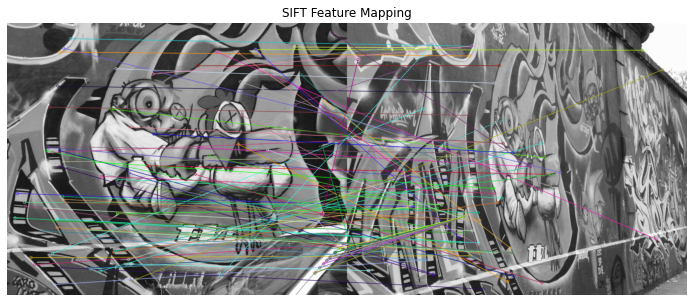

In [10]:
img1 = cv.imread("Images/graf/img1.ppm", cv.IMREAD_GRAYSCALE)
img5 = cv.imread("Images/graf/img5.ppm", cv.IMREAD_GRAYSCALE)

assert img1 is not None
assert img5 is not None

# Initiate SIFT detector with values used in D. Lowe paper
sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=25, sigma=1)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp5, des5 = sift.detectAndCompute(img5, None)

# draw keypoints
img1_kp = cv.drawKeypoints(img1, kp1, img1)
img5_kp = cv.drawKeypoints(img5, kp5, img5)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des5, k=2)

# Apply ratio test
good = [] # good matches
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

matches_im = cv.drawMatchesKnn(img1, kp1, img5, kp5, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(img1_kp)
axs[1].imshow(img5_kp)

axs[0].set_title("Image 1 SIFT Features")
axs[1].set_title("Image 5 SIFT Features")

axs[0].axis("off")
axs[1].axis("off")

plt.figure(figsize=(15,5))
plt.imshow(matches_im)
plt.title("SIFT Feature Mapping")
plt.axis('off')

plt.show()

### b)

In [11]:
def get_homography(X, Y):
    A = []
    zeros = np.array([0,0,0])

    # create matrix A
    for i in range(4):
        A.append(np.hstack((X[i, :], zeros, (-1*Y.T[0, i]*X[i,:]))))
        A.append(np.hstack((zeros, X[i, :], (-1*Y.T[1, i]*X[i,:]))))
    
    A = np.array(A).squeeze().astype(np.float64)
    
    # find the eigen vector h corresponding to the smallest eigen value 
    eigen_values, eigen_vectors = np.linalg.eig(A.T @ A)
    col_idx = np.argmin(eigen_values) 
    H = eigen_vectors[:, col_idx]

    # rearrange to get the Homography transformation matrix
    H = H.reshape(3, -1)

    return H

In [12]:
def get_SIFT_features(im_path1, im_path2):
    img1 = cv.imread(im_path1, cv.IMREAD_GRAYSCALE)
    img5 = cv.imread(im_path2, cv.IMREAD_GRAYSCALE)

    assert img1 is not None
    assert img5 is not None

    # Initiate SIFT detector with values used in D. Lowe paper
    sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=.09, edgeThreshold=25, sigma=1)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp5, des5 = sift.detectAndCompute(img5, None)

    # # draw keypoints
    # img1_kp = cv.drawKeypoints(img1, kp1, img1)
    # img5_kp = cv.drawKeypoints(img5, kp5, img5)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des5, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    # matches_im = cv.drawMatchesKnn(img1, kp1, img5, kp5, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    good = np.array(good).squeeze()

    return good, kp1, kp5



def get_inliers(X_all, Y_all, H, t, X_inliers, Y_inliers):
    count = 0

    trans_X_all = H @ X_all
    trans_X_all = trans_X_all / trans_X_all[2, :]

    error = np.sqrt(np.sum((Y_all - trans_X_all)**2, axis=0))

    inlier_idx = np.where(error <= t)[0]

    X_inliers = np.hstack((X_inliers, X_all[:, inlier_idx]))
    Y_inliers = np.hstack((Y_inliers, Y_all[:, inlier_idx]))

    count = inlier_idx.shape[0]

    return X_inliers, Y_inliers, count



def RANSAC(im_path1, im_path2, t, d, N):
    # Number of random points needed to be sampled is 4
    s = 4

    best_fit_homography = None
    best_inlier_count = 0

    matches, kp1, kp2 = get_SIFT_features(im_path1, im_path2)

    X_all = np.zeros((len(matches), 3))
    Y_all = np.zeros((len(matches), 3))

    for i, match in enumerate(matches):
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt

        X_all[i, :] = np.array([p1[0], p1[1], 1])
        Y_all[i, :] = np.array([p2[0], p2[1], 1])

    for _ in range(N):
        
        while True:
            # sample s = 4 distinct points
            x = np.random.randint(0, len(matches), (4))
            if len(np.unique(x)) == 4:
                break

        X = np.zeros((4, 3))
        Y = np.zeros((4, 3))

        for i, idx in enumerate(x):
            match = matches[idx]

            p1 = kp1[match.queryIdx].pt
            p2 = kp2[match.trainIdx].pt

            X[i, :] = np.array([p1[0], p1[1], 1])
            Y[i, :] = np.array([p2[0], p2[1], 1])

        X_inliers = np.zeros((3, 1))
        Y_inliers = np.zeros((3, 1))

        H = get_homography(X, Y)

        X_inliers, Y_inliers, count = get_inliers(X_all.T, Y_all.T, H, t, X_inliers, Y_inliers)

        X_inliers = np.delete(X_inliers, 0, axis=1)
        Y_inliers = np.delete(Y_inliers, 0, axis=1)

        if count > best_inlier_count:
            best_fit_homography = H
            best_inlier_count = count

    return best_fit_homography

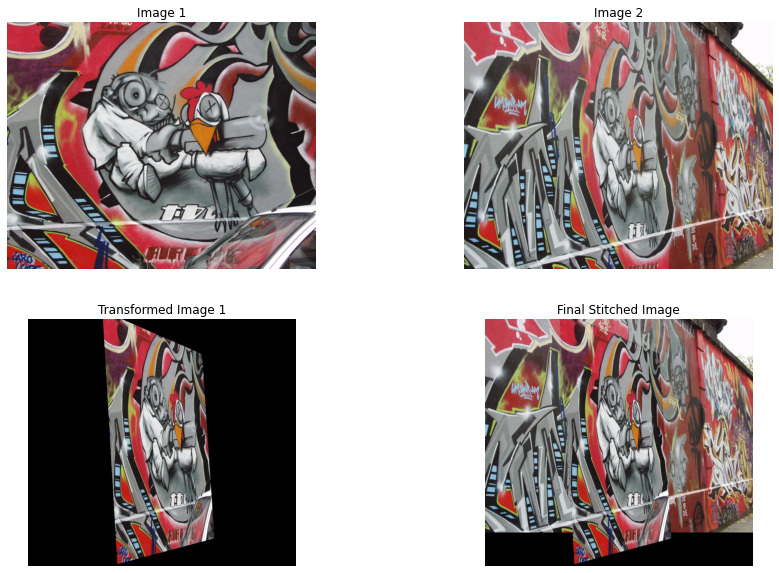

In [14]:
# calculate homography in two parts
H1to4  = RANSAC("Images/graf/img1.ppm", "Images/graf/img4.ppm", 1, 20, 10000)
H4to5  = RANSAC("Images/graf/img4.ppm", "Images/graf/img5.ppm", 1, 20, 10000)

# composition matrix
H1to5 = H4to5 @ H1to4

# read images in color
img1 = cv.imread("Images/graf/img1.ppm")
img5 = cv.imread("Images/graf/img5.ppm")

# perfrom the homographic transformation on img1
trans_img_1 = cv.warpPerspective(img1, H1to5, dsize=(img1.shape[1], img1.shape[0]+100))

# maake a copy for stitching
stitched_img = np.copy(trans_img_1)

for i in range(stitched_img.shape[0]):
    for j in range(stitched_img.shape[1]):
        if np.all(stitched_img[i,j] == 0) and i < img5.shape[0] and j < img5.shape[1]:
            stitched_img[i,j] = img5[i,j]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0][0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
axs[0][1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
axs[1][0].imshow(cv.cvtColor(trans_img_1, cv.COLOR_BGR2RGB))
axs[1][1].imshow(cv.cvtColor(stitched_img, cv.COLOR_BGR2RGB))

axs[0][0].axis("off")
axs[0][1].axis("off")
axs[1][0].axis("off")
axs[1][1].axis("off")

axs[0][0].set_title("Image 1")
axs[0][1].set_title("Image 2")
axs[1][0].set_title("Transformed Image 1")
axs[1][1].set_title("Final Stitched Image")
plt.show()

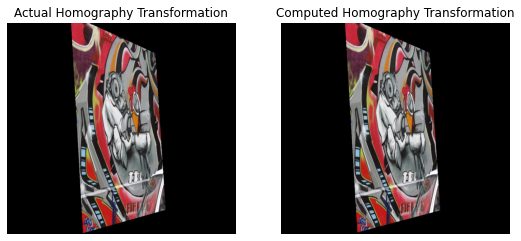

In [20]:
# read the actual homography from file
with open("Images/graf/H1to5p") as f:
    actual_H = f.read()
    actual_H = actual_H.split('\n')
    actual_H.pop()

    for i in range(len(actual_H)):
        actual_H[i] = list(map(float, actual_H[i].strip().split()))
    
    actual_H = np.array(actual_H)
    
# transform using actual homography matrix
actual_trans_img = cv.warpPerspective(img1, actual_H, dsize=(img1.shape[1], img1.shape[0]+100))

fig, ax = plt.subplots(1, 2, figsize=(9, 5))

ax[0].imshow(cv.cvtColor(actual_trans_img, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(trans_img_1, cv.COLOR_BGR2RGB))

ax[0].set_title("Actual Homography Transformation")
ax[1].set_title("Computed Homography Transformation")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

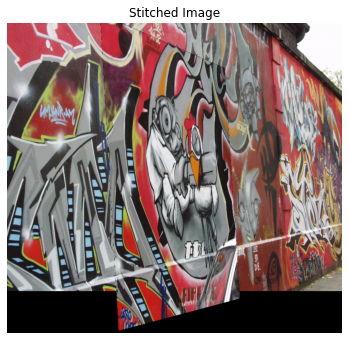

In [21]:
# Showing the stiched image
plt.figure(figsize=(6,6))
plt.imshow(cv.cvtColor(stitched_img, cv.COLOR_BGR2RGB))
plt.title("Stitched Image")
plt.axis('off')
plt.show()

In [22]:
# results 
print(f"Computed Homography:\n{H1to5}")
print(f"Actual Homography:\n{actual_H}")

computed =  H1to5 / H1to5[2,2]
error = np.sum(np.square(computed - actual_H))

print(f"SSD: {error}")
print(f"computed homography accounting for lambda: \n{computed}")

Computed Homography:
[[ 1.22030144e-05  1.20665735e-06  4.41203294e-03]
 [ 4.21347813e-06  2.30115708e-05 -4.35238295e-04]
 [ 9.26556851e-09 -6.71014542e-10  1.98832537e-05]]
Actual Homography:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]
SSD: 13.821654362102258
computed homography accounting for lambda: 
[[ 6.13733275e-01  6.06871174e-02  2.21896929e+02]
 [ 2.11910897e-01  1.15733426e+00 -2.18896918e+01]
 [ 4.65998605e-04 -3.37477231e-05  1.00000000e+00]]
